# Check data as a beganning 

In [1]:
import pandas as pd

file_path = 'train.csv'

df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


# 📊 Dataset Overview: Porto Taxi Trajectories

This dataset contains a **full year (01/07/2013 to 30/06/2014)** of taxi trip data from **442 taxis** operating in the city of **Porto, Portugal**. Each row in the dataset represents a **completed trip**, and the dataset includes detailed information about how the trip was requested, the taxi driver, the timestamp, and the GPS trajectory.

---

## 🔍 Column Descriptions

| Column Name     | Type     | Description |
|-----------------|----------|-------------|
| **TRIP_ID**     | Integer   | A unique identifier for each trip. |
| **CALL_TYPE**   | Char     | Describes how the trip was requested: <br> - `'A'`: Central dispatch (called by customer) <br> - `'B'`: Picked up at a taxi stand <br> - `'C'`: Hailed randomly on the street |
| **ORIGIN_CALL** | Integer  | An anonymous ID for the customer who made the call (only present if `CALL_TYPE` = 'A'). `NaN` otherwise. |
| **ORIGIN_STAND**| Integer  | ID of the taxi stand where the trip started (only present if `CALL_TYPE` = 'B'). `NaN` otherwise. |
| **TAXI_ID**     | Integer  | A unique identifier for the taxi driver who completed the trip. |
| **TIMESTAMP**   | Integer  | Unix timestamp representing the start time of the trip (in seconds). Can be converted to human-readable datetime. |
| **DAYTYPE**     | Char     | Type of the day when the trip started: <br> - `'A'`: Normal day (workday or weekend) <br> - `'B'`: Holiday or special day <br> - `'C'`: Day before a holiday |
| **MISSING_DATA**| Boolean  | `FALSE` means complete GPS data is present, `TRUE` indicates some GPS points are missing. |
| **POLYLINE**    | String (List of Lists) | A list of GPS coordinates (longitude, latitude) recorded every 15 seconds during the trip. It shows the complete route taken by the taxi. The length of this list determines the trip duration. |

---

## 🎯 Prediction Target (for competition)

The **total travel time** of a trip is defined as:

**Trip Time (seconds)** = (Number of GPS points - 1) × 15



---

## 💡 Notes
- Some fields like `ORIGIN_CALL` and `ORIGIN_STAND` are conditionally null depending on the `CALL_TYPE`.
- The `POLYLINE` field contains valuable geo-spatial data but needs to be parsed from a string into a list.
- The dataset is useful for tasks like **trip duration prediction**, **route clustering**, and **geo-spatial analysis**.



# Now let's check for outliters
specially focusing on the timestamp

In [2]:
df.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP
count,1.710670e+06,364770.000000,806579.000000,1.710670e+06,1.710670e+06
mean,1.388622e+18,24490.363018,30.272381,2.000035e+07,1.388622e+09
std,9.180944e+15,19624.290043,17.747840,2.112405e+02,9.180944e+06
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09
25%,1.380731e+18,6593.000000,15.000000,2.000017e+07,1.380731e+09
50%,1.388493e+18,18755.000000,27.000000,2.000034e+07,1.388493e+09
75%,1.396750e+18,40808.000000,49.000000,2.000052e+07,1.396750e+09
max,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09


there is no anomilies in the timestamp indecating a valid data

# Make sure there is no duplicated trips by checking the trip ID

In [3]:
# pd.set_option('display.max_rows', None)
duplicated_trip_ids = df['TRIP_ID'].value_counts()[lambda x: x > 1]
duplicated_trip_ids

TRIP_ID
1397172149620000454    3
1402085470620000527    2
1389002485620000685    2
1393869017620000066    2
1389782974620000562    2
                      ..
1400060661620000080    2
1394034338620000328    2
1373025987620000601    2
1394118360620000066    2
1373210896620000598    2
Name: count, Length: 80, dtype: int64

### 🕵️‍♂️ **NAUGHTY VALUES MUST BE PRUNED ASAP** 🤣

After observing the previous results, we can clearly see that some trips exist more than once...

You have **two options**:

1. **Option 1**: Delete only the **later occurrences** of each `TRIP_ID` (keeping the first occurrence).
2. **Option 2**: Delete **all duplicated instances**, effectively keeping only unique `TRIP_ID`s.

# Which option to choose?
The idea is to check the other columns of each record to check if they are exactly the same

1. if they are the same you can keep one of them
2. if they are totally different then I would assume that this data is not accurate nor can be trusted so we will delete it all


In [4]:
df[df['TRIP_ID'].isin(duplicated_trip_ids.index)]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
3519,1372702836620000080,B,NaN,16.0,20000080,1372702836,A,False,"[[-8.635275,41.193729],[-8.634519,41.192901]]"
3720,1372702836620000080,C,NaN,NaN,20000080,1372702836,A,False,"[[-8.62776,41.17554],[-8.62776,41.17554],[-8.6..."
21282,1373025987620000601,A,2002.0,NaN,20000601,1373025987,A,False,[]
21385,1373025987620000601,C,NaN,NaN,20000601,1373025987,A,False,"[[-8.604108,41.182569],[-8.604072,41.182605],[..."
33228,1373210896620000598,B,NaN,57.0,20000598,1373210896,A,False,"[[-8.610885,41.145525]]"
...,...,...,...,...,...,...,...,...,...
1665302,1403407180620000242,C,NaN,NaN,20000242,1403407180,A,False,[]
1684526,1403716904620000337,C,NaN,NaN,20000337,1403716904,A,False,"[[-8.654913,41.182821],[-8.656623,41.182317],[..."
1684739,1403716904620000337,C,NaN,NaN,20000337,1403716904,A,False,"[[-8.654913,41.182821],[-8.656623,41.182317],[..."
1705646,1404093316620000307,B,NaN,57.0,20000307,1404093316,A,False,"[[-8.610831,41.145741]]"


# Prune them all 💣
as observed above the data is completely different in each record and they are only 161 record which won't affect our data integrity at all

In [5]:
df = df[df['TRIP_ID'].duplicated(keep=False) == False]

df['TRIP_ID'].value_counts()[lambda x: x > 1] #Make sure they are deleted


Series([], Name: count, dtype: int64)

# TimeStamp
time stamp is not human readable nor understandable by a human therefore we must make a new datatime column

In [6]:
df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit='s')

df['datetime']

0         2013-07-01 00:00:58
1         2013-07-01 00:08:23
2         2013-07-01 00:02:31
3         2013-07-01 00:00:54
4         2013-07-01 00:04:51
                  ...        
1710665   2014-06-30 23:37:43
1710666   2014-06-30 23:36:07
1710667   2014-01-03 10:41:56
1710668   2014-06-30 15:23:46
1710669   2014-06-30 19:39:07
Name: datetime, Length: 1710509, dtype: datetime64[ns]

# Mapping Encoded Categories to Descriptive Labels

First we make sure that there isn't any anomiies

In [7]:
df['CALL_TYPE'].unique()

array(['C', 'B', 'A'], dtype=object)

Now we start the mapping process

In [8]:
callTypeMap= {
'A' : 'Central',
'B' : 'Stand',
'C' : 'Street'
}

df['CALL_TYPE'] = df['CALL_TYPE'].map(callTypeMap)


In [9]:
df['CALL_TYPE'].unique() 

array(['Street', 'Stand', 'Central'], dtype=object)

# Also map the day type so it can be meaningful 

In [10]:
dayTypeMap={
    'A':'Normal', 
    'B':'Holiday',
    'C':'Before_Holiday'
}

df['DAY_TYPE'] = df['DAY_TYPE'].map(dayTypeMap)

In [11]:
df['DAY_TYPE'].unique()

array(['Normal'], dtype=object)

<span style="color:red">Something seems wrong here. Holidays are not classifed at all all days are classfied as NORMAL</span>

# Finding a solution to classify the days

**there is a library called holidays that can help us with that problem** 

In [12]:
import holidays

portugalHolidays= holidays.country_holidays('PT',subdiv='13') # Don't forget that this data is only based on the ciry Porto (13) in portugal and that is why we used its holidays specifically

portugalHolidays

holidays.country_holidays('PT', subdiv='13')

**The function responsible for the parsing**

In [13]:
from datetime import timedelta

def modifyDayType(r):
    if r['datetime'] in portugalHolidays:
        r['DAY_TYPE'] = 'Holiday'
    elif (r['datetime'] + timedelta(days=1)) in portugalHolidays:
        r['DAY_TYPE'] = 'Before_Holiday'
    
    return r

Now we will satrt parsing **يارب يشتغل عشان معيطش**

In [14]:
df = df.apply(modifyDayType,axis=1)

In [15]:
df['DAY_TYPE'].unique()

array(['Normal', 'Before_Holiday', 'Holiday'], dtype=object)

**<span style="color:GREEN">IT FINALLY WORKEDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD :></span>** 

In [16]:
df['DAY_TYPE'].value_counts()

DAY_TYPE
Normal            1613820
Before_Holiday      49997
Holiday             46692
Name: count, dtype: int64

In [17]:
df.count()

TRIP_ID         1710509
CALL_TYPE       1710509
ORIGIN_CALL      364765
ORIGIN_STAND     806561
TAXI_ID         1710509
TIMESTAMP       1710509
DAY_TYPE        1710509
MISSING_DATA    1710509
POLYLINE        1710509
datetime        1710509
dtype: int64

# Dealing with polylines 🥲🫢
We can just delete all the data with missing coordinates, but where is the fun in that huh?

`To reach the light, you must first go through the darkness.`

In [18]:
from math import radians, cos, sin, asin, sqrt

def haversine(coord1, coord2): # This algorithm is responsible for accurately calcualting the distance between two points
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6371 * c
    return km

def interpolate_coords(coord1, coord2, num_points):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    lons = [lon1 + i*(lon2 - lon1)/(num_points+1) for i in range(1, num_points+1)]
    lats = [lat1 + i*(lat2 - lat1)/(num_points+1) for i in range(1, num_points+1)]
    return list(zip(lons, lats))

def calculate_total_distance(polyline):
    total_distance = 0
    for i in range(1, len(polyline)):
        total_distance += haversine(polyline[i-1], polyline[i])
    return total_distance

def calculate_time(polyline):
    total_time_minutes = 15 * (len(polyline) - 1)  / 60
    return total_time_minutes 



In [19]:
def interpolate_polyline(polyline, threshold_km=0.3, max_interp_points=3):  #A function that will apply the interpolation to the polylines
    if len(polyline) < 2:
        return polyline
    
    fixed_polyline = [polyline[0]]
    
    for i in range(1, len(polyline)):
        prev = polyline[i-1]
        curr = polyline[i]
        dist = haversine(prev, curr)
        
        if dist > threshold_km:
            num_interp = min(int(dist // threshold_km), max_interp_points)
            new_points = interpolate_coords(prev, curr, num_interp)
            fixed_polyline.extend(new_points)
        
        fixed_polyline.append(curr)
    
    return fixed_polyline


# Parse the string literal to a list


In [20]:
# tempdf = df[df['MISSING_DATA'] == False]

import ast

df['POLYLINE_PARSED'] = df['POLYLINE'].apply(
    lambda x: [[coord[1], coord[0]] for coord in ast.literal_eval(x)]
)
df.drop('POLYLINE', axis=1, inplace=True) # Dropping this column to free up some memory
df['POLYLINE_PARSED']

0          [[41.141412, -8.618643], [41.141376, -8.618499...
1          [[41.159826, -8.639847], [41.159871, -8.640351...
2          [[41.140359, -8.612964], [41.14035, -8.613378]...
3          [[41.151951, -8.574678], [41.151942, -8.574705...
4          [[41.18049, -8.645994], [41.180517, -8.645949]...
                                 ...                        
1710665    [[41.14602, -8.612469], [41.145993, -8.612487]...
1710666    [[41.140845, -8.610138], [41.140935, -8.610174...
1710667                                                   []
1710668    [[41.154885, -8.630712], [41.154813, -8.63073]...
1710669    [[41.140629, -8.615538], [41.140746, -8.615421...
Name: POLYLINE_PARSED, Length: 1710509, dtype: object

# How can we determine the best threshold?
We can check the average speed in the complete polylines which will then determine the best threshold possible

In [21]:
# tempdf = df[df['MISSING_DATA'] == False]

# def calcAll(polyLine):
#      time = calculate_time(polyLine)
#      distance = calculate_total_distance(polyLine)
#      speed = distance/time
#      return distance,time,speed

df['Distance_KM'] = df['POLYLINE_PARSED'].apply(calculate_total_distance)


df['Distance_KM']


0           3.182784
1           4.392363
2          22.424318
3          10.123073
4           5.903336
             ...    
1710665     3.312913
1710666     4.513655
1710667     0.000000
1710668     6.377982
1710669     2.652487
Name: Distance_KM, Length: 1710509, dtype: float64

In [22]:
df['Distance_KM'].describe()

count    1.710509e+06
mean     6.450295e+00
std      8.844745e+00
min      0.000000e+00
25%      2.777649e+00
50%      4.654364e+00
75%      7.799993e+00
max      1.610191e+03
Name: Distance_KM, dtype: float64

# Investigate distances that are 0

In [23]:
len(df[df['Distance_KM'] == 0])

36621

# Prune them

In [24]:
df = df[df['Distance_KM'] != 0]

len(df[df['Distance_KM'] == 0])

0

# Defind a function for boxplot and scatter plot to minimize code redundancy

In [25]:
import matplotlib.pyplot as plt
def boxPlot_ScaterPlot(points,name):


    plt.figure(figsize=(12, 5))

    # Boxplot
    plt.subplot(1, 2, 1)
    plt.boxplot(points, vert=False)
    plt.title(f"Boxplot of {name.split(" ")[0]}")
    plt.xlabel(name)

    # Scatter plot
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(points)), points, color='skyblue')
    plt.title(f"{name.split(" ")[0]} Scatter Plot")
    plt.xlabel("Index")
    plt.ylabel(name)

    # # Highlight values greater than a threshold as outliers (you can adjust this)
    # threshold = distances_km.mean() + 3 * distances_km.std()
    # for i, value in enumerate(distances_km):
    #     if value > threshold:
    #         plt.scatter(i, value, color='red')
    #         plt.text(i, value + 20, f"{value:.2f} km", color='red', ha='center')

    plt.tight_layout()
    return plt.show()

# There is clearly an outlier which we need to deal with first

Let's visualise it first

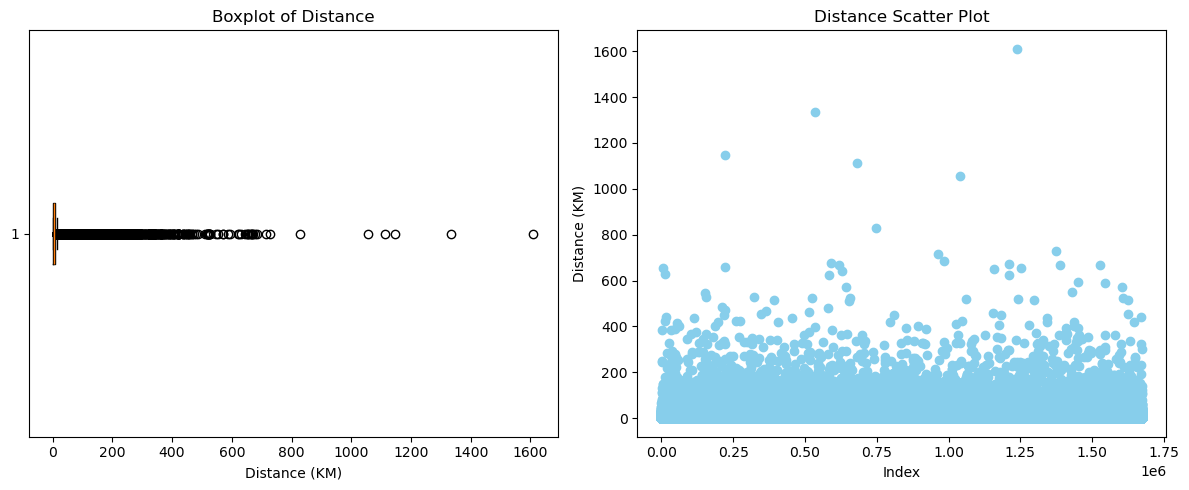

In [26]:

boxPlot_ScaterPlot(df['Distance_KM'],'Distance (KM)')

# ~~Using IQR for efficiency and fast parsing~~
# Changing the method of cleaning
Instead of IQR we will set a considerable upper bound by ourselves to avoid pruning valid trips

In [27]:
# Q1 = df['Distance_KM'].quantile(0.25)
# Q3 = df['Distance_KM'].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 5 * IQR
# upper_bound = Q3 + 5 * IQR


df =  df[(df['Distance_KM'] <= 200) ]

df['Distance_KM'].describe()

count    1.673460e+06
mean     6.511191e+00
std      6.925931e+00
min      9.892410e-04
25%      2.880935e+00
50%      4.743342e+00
75%      7.903518e+00
max      1.997850e+02
Name: Distance_KM, dtype: float64

# Visualize again

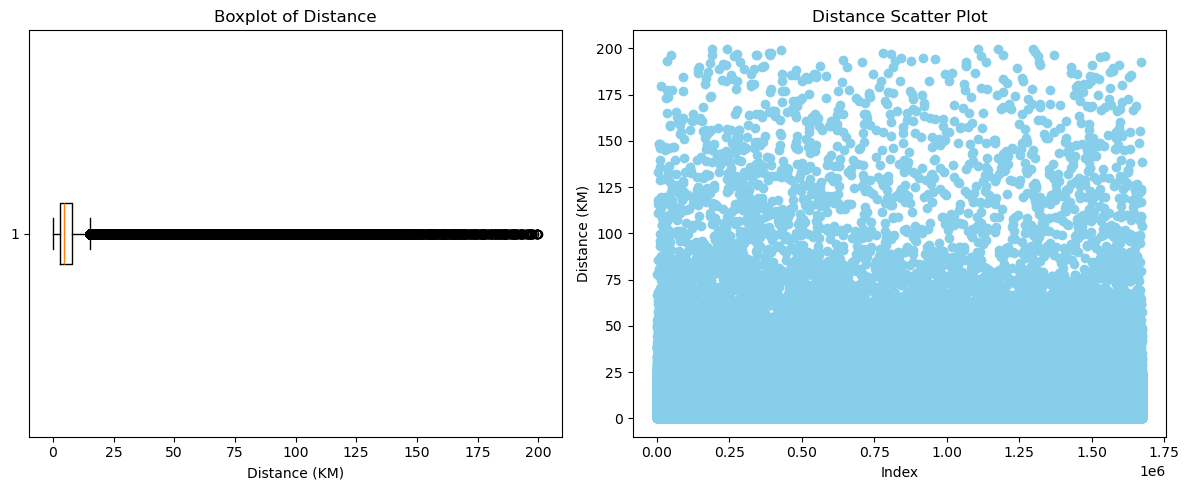

In [28]:
boxPlot_ScaterPlot(df['Distance_KM'],'Distance (KM)')

In [29]:
df[df['Distance_KM'] < 1] #Very short trips won't be pruned

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,datetime,POLYLINE_PARSED,Distance_KM
25,1372639092620000233,Street,NaN,NaN,20000233,1372639092,Normal,False,2013-07-01 00:38:12,"[[41.168295, -8.632737], [41.16825, -8.6328], ...",0.027935
68,1372637926620000173,Street,NaN,NaN,20000173,1372637926,Normal,False,2013-07-01 00:18:46,"[[41.173335, -8.642133], [41.172831, -8.64081]]",0.157199
100,1372638513620000473,Central,63882.0,NaN,20000473,1372638513,Normal,False,2013-07-01 00:28:33,"[[41.181759, -8.601273], [41.181768, -8.601246...",0.053296
120,1372642351620000005,Street,NaN,NaN,20000005,1372642351,Normal,False,2013-07-01 01:32:31,"[[41.149953, -8.614107], [41.14998, -8.614746]...",0.767187
137,1372640078620000333,Street,NaN,NaN,20000333,1372640078,Normal,False,2013-07-01 00:54:38,"[[41.149161, -8.599257], [41.148387, -8.598492...",0.624506
...,...,...,...,...,...,...,...,...,...,...,...
1710603,1404172736620000483,Street,NaN,NaN,20000483,1404172736,Normal,False,2014-06-30 23:58:56,"[[41.175504, -8.58609], [41.174955, -8.586351]...",0.521707
1710615,1404165476620000243,Street,NaN,NaN,20000243,1404165476,Normal,False,2014-06-30 21:57:56,"[[41.158674, -8.5779], [41.158683, -8.577891]]",0.001407
1710622,1376053063620000981,Street,NaN,NaN,20000981,1376053063,Normal,False,2013-08-09 12:57:43,"[[41.162454, -8.623521], [41.162697, -8.623701...",0.038364
1710648,1404171548620000364,Street,NaN,NaN,20000364,1404171548,Normal,False,2014-06-30 23:39:08,"[[41.123385, -8.614323], [41.123385, -8.614152...",0.104010


# Calcualte time

In [30]:
df['Trip_duration_mins'] = df['POLYLINE_PARSED'].apply(calculate_time)

df['Trip_duration_mins'].describe()

count    1.673460e+06
mean     1.214957e+01
std      1.063570e+01
min      2.500000e-01
25%      7.000000e+00
50%      1.025000e+01
75%      1.450000e+01
max      9.677500e+02
Name: Trip_duration_mins, dtype: float64

# Prune outliers 

In [31]:
Q1 = df['Trip_duration_mins'].quantile(0.25)
Q3 = df['Trip_duration_mins'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR #Some trips might be long and that is okay but here we are focusing on the mean so i will delete most long trips to get a good average
upper_bound = Q3 + 1.5 * IQR


df = df[(df['Trip_duration_mins'] >= lower_bound) & (df['Trip_duration_mins'] <= upper_bound) ]

df['Trip_duration_mins'].describe()


count    1.592756e+06
mean     1.062225e+01
std      5.150640e+00
min      2.500000e-01
25%      6.750000e+00
50%      1.000000e+01
75%      1.375000e+01
max      2.575000e+01
Name: Trip_duration_mins, dtype: float64

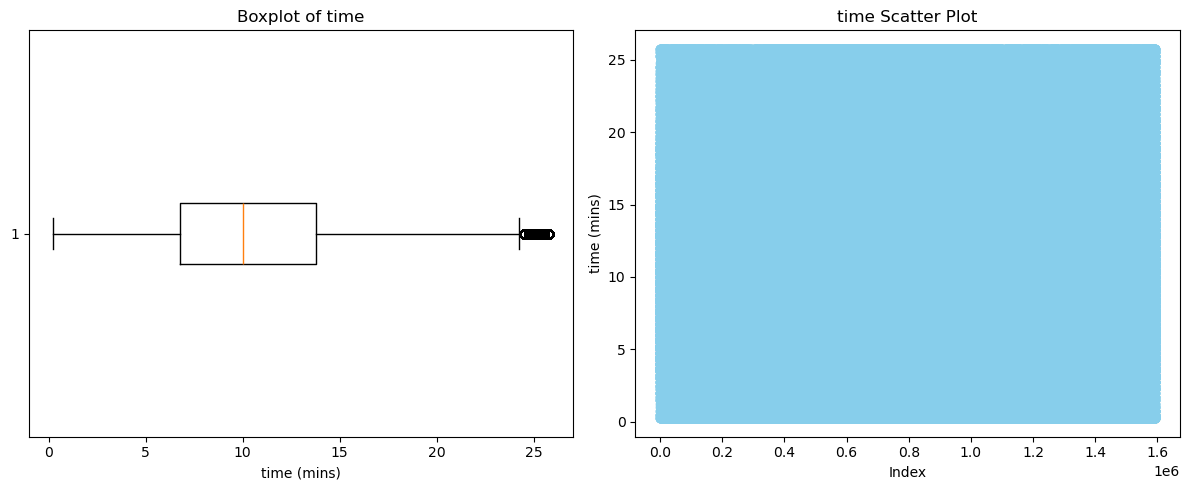

In [32]:
boxPlot_ScaterPlot(df['Trip_duration_mins'],'time (mins)')

# Claculae speed

In [33]:
df['Speed_KPH'] = df['Distance_KM'] / (df['Trip_duration_mins'] / 60)

df['Speed_KPH'].describe()

count    1.592756e+06
mean     3.237375e+01
std      1.970752e+01
min      4.803621e-02
25%      2.134611e+01
50%      2.842060e+01
75%      3.907615e+01
max      3.856648e+03
Name: Speed_KPH, dtype: float64

# Prune outliers in speed

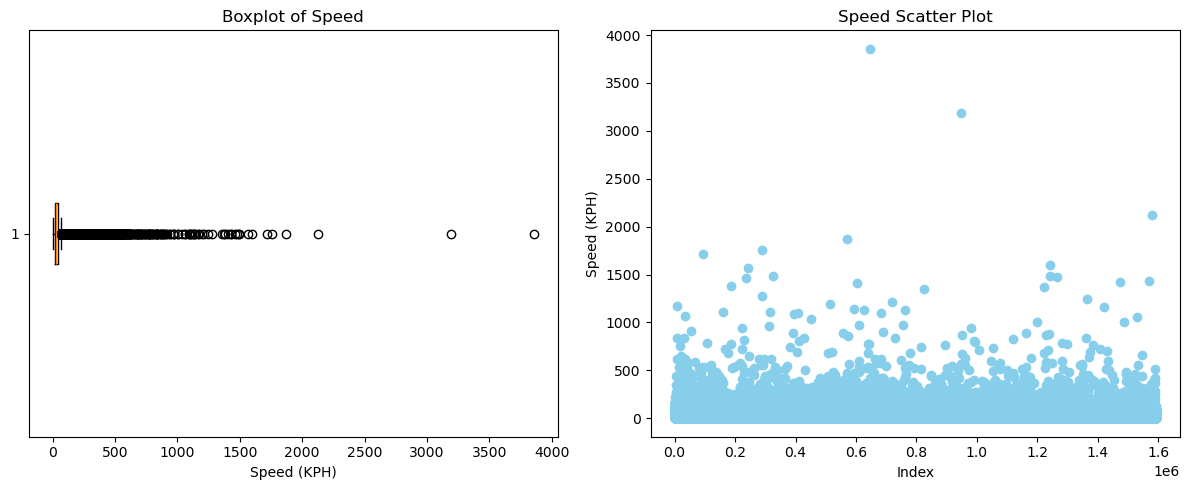

In [34]:
boxPlot_ScaterPlot(df['Speed_KPH'],'Speed (KPH)')

# Clean speed outliers

In [35]:
Q1 = df['Speed_KPH'].quantile(0.25)
Q3 = df['Speed_KPH'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR #Some trips might be long and that is okay but here we are focusing on the mean so i will delete most long trips to get a good average
upper_bound = Q3 + 1.5 * IQR


df = df[(df['Speed_KPH'] >= lower_bound) & (df['Speed_KPH'] <= upper_bound) ]

df['Speed_KPH'].describe()

count    1.521465e+06
mean     2.998815e+01
std      1.259223e+01
min      4.803621e-02
25%      2.102612e+01
50%      2.773460e+01
75%      3.709394e+01
max      6.567114e+01
Name: Speed_KPH, dtype: float64

# Visualize again

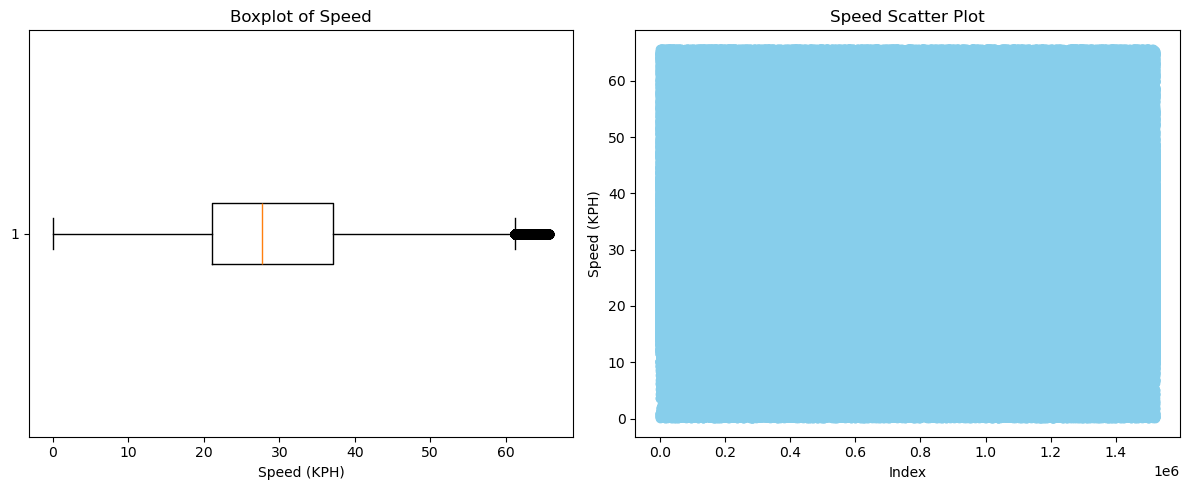

In [36]:
boxPlot_ScaterPlot(df['Speed_KPH'],'Speed (KPH)')

# Insights
The average speed of a trip is around 30 this number will help us in calcuating the interpolition line in the missing data

`All of this just for getting the mean of the speed, I might as well just KMS🥲`


**Don't forget to delete useless variables that are no longer needed**

In [37]:
# import gc
# # del tempdf, pruned, upper_bound, lower_bound, distances_km, Trip_duration_mins
# gc.collect()

<span style="color:red">The cell above was commented out due to changes that made code more efficient so no longer need for it</span>

# HI there
this markdown cell is from the furutre and it is telling you to flip the langtitude and latitude before it is too late

**you probole don't understand so let me explain for you... the polyline points right now is formated (lon,lat) which is too confusing when working with and mapping**

In [38]:
# df['POLYLINE_PARSED'] = df['POLYLINE_PARSED'].apply(  #This will probably take some time
#     lambda polyline: [[lat, lon] for lon, lat in polyline]
# ) 

`The above cell was combined with the polyline parsing step`

# Create a function that visualizes trips to minimize code redundancy

In [39]:
import folium
def MapPlot(polyline_points):
    # polyline_points = [[lat, lon] for lon, lat in points]
    length = len(polyline_points)


        
    # Center map on Porto
    m = folium.Map(location=[sum(x[0] for x in polyline_points)/length, sum(x[1] for x in polyline_points)/length], zoom_start=14)


    for lat, lon in polyline_points:
        folium.Marker([lat, lon]).add_to(m)

    folium.PolyLine(polyline_points, color="blue", weight=2.5, opacity=1).add_to(m)

    folium.Marker([polyline_points[0][0], polyline_points[0][1]], popup="Start", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker([polyline_points[-1][0], polyline_points[-1][1]], popup="End", icon=folium.Icon(color="red")).add_to(m)
    return m  

def MapPloyLine(polyline_points):
    # polyline_points = [[lat, lon] for lon, lat in points]
    length = len(polyline_points)


        
    # Center map on Porto
    m = folium.Map(location=[sum(x[0] for x in polyline_points)/length, sum(x[1] for x in polyline_points)/length], zoom_start=14)


    # for lat, lon in polyline_points:
    #     folium.Marker([lat, lon]).add_to(m)

    folium.PolyLine(polyline_points, color="blue", weight=2.5, opacity=1).add_to(m)

    folium.Marker([polyline_points[0][0], polyline_points[0][1]], popup="Start", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker([polyline_points[-1][0], polyline_points[-1][1]], popup="End", icon=folium.Icon(color="red")).add_to(m)
    return m  


In [40]:



points = list(df.iloc[0]['POLYLINE_PARSED'])
MapPlot(points)

# Visualize a trip with missing points

In [41]:



points = list(df[df['MISSING_DATA'] == True].iloc[0]['POLYLINE_PARSED'])
MapPlot(points)


# An observation
Using interpolation won't be accurate because it might map to point that is not a road... we need something more accurate

**For now we need to stick with basic interpolition and the haversine function because if we want more accurate data we need an external API like google maps API to accurately calcualting the distance and other values**

`Maybe in the future when I'm rich, I will do it using the google maps API💰💸`

# Testing the interpolation algoirthm on one record
-  First we will create a function that shows the new points

`Points that are greyish are the points that have been added`


In [42]:
def mapPointsDiff(polyline_points,thershold=0.3):
    length = len(polyline_points)

    newPoints = interpolate_polyline(polyline_points,thershold)
        
    # Center map on Porto
    m = folium.Map(location=[sum(x[0] for x in polyline_points)/length, sum(x[1] for x in polyline_points)/length], zoom_start=14)


    for lat, lon in newPoints:
        folium.Marker([lat, lon],icon=folium.Icon(color='cadetblue')).add_to(m)

        
    for lat, lon in polyline_points:
        folium.Marker([lat,lon],icon=folium.Icon(color='blue')).add_to(m)

    folium.PolyLine(newPoints, color="blue", weight=2.5, opacity=1).add_to(m)

    folium.Marker([polyline_points[0][0], polyline_points[0][1]], popup="Start", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker([polyline_points[-1][0], polyline_points[-1][1]], popup="End", icon=folium.Icon(color="red")).add_to(m)
    return m  

In [43]:
r = df[df['MISSING_DATA'] == True].iloc[0] 
    
mapPointsDiff(r['POLYLINE_PARSED'],0.4)


<span style="color:green">Interpolition seems good</span>

In [44]:
df.loc[df['MISSING_DATA'] == True, 'POLYLINE_PARSED'] = df.loc[
    df['MISSING_DATA'] == True, 'POLYLINE_PARSED'
].apply(lambda x: interpolate_polyline(x, threshold_km=0.3))

In [45]:
r = df[df['MISSING_DATA'] == True].iloc[2] 
    
MapPlot(r['POLYLINE_PARSED'])

In [46]:
df[df['MISSING_DATA'] == True]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,datetime,POLYLINE_PARSED,Distance_KM,Trip_duration_mins,Speed_KPH
105621,1374554455620000625,Stand,NaN,23.0,20000625,1374554455,Normal,True,2013-07-23 04:40:55,"[[41.145975, -8.612559], [41.145975, -8.612577...",5.105386,10.50,29.173636
782321,1387137779620000640,Street,NaN,NaN,20000640,1387137779,Normal,True,2013-12-15 20:02:59,"[[41.161941, -8.604558], [41.162013, -8.604477...",9.751256,12.50,46.806027
848552,1388351478620000678,Central,9738.0,NaN,20000678,1388351478,Normal,True,2013-12-29 21:11:18,"[[41.160276, -8.609697], [41.16033, -8.609571]...",4.053854,6.50,37.420193
932391,1390005983620000640,Street,NaN,NaN,20000640,1390005983,Normal,True,2014-01-18 00:46:23,"[[41.16123, -8.604792], [41.161167, -8.604801]...",1.693427,3.25,31.263263
1432196,1399405185620000508,Street,NaN,NaN,20000508,1399405185,Normal,True,2014-05-06 19:39:45,"[[41.14683, -8.620011], [41.146659, -8.619957]...",13.888660,13.00,64.101507


# Recalculate Distance, Time and speed

In [47]:
def reCalc(r):
    # r['Distance_KM'] = calculate_total_distance(r['POLYLINE_PARSED']) since the points are plotted between each point the distance will never change in any case
    r['Trip_duration_mins'] = calculate_time(r['POLYLINE_PARSED'])
    r['Speed_KPH'] = r['Distance_KM'] / (r['Trip_duration_mins'] / 60)
    return r

df.loc[df['MISSING_DATA'] == True] = df.loc[df['MISSING_DATA'] == True].apply(reCalc, axis=1)

df.loc[df['MISSING_DATA'] == True]


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,datetime,POLYLINE_PARSED,Distance_KM,Trip_duration_mins,Speed_KPH
105621,1374554455620000625,Stand,NaN,23.0,20000625,1374554455,Normal,True,2013-07-23 04:40:55,"[[41.145975, -8.612559], [41.145975, -8.612577...",5.105386,11.00,27.847562
782321,1387137779620000640,Street,NaN,NaN,20000640,1387137779,Normal,True,2013-12-15 20:02:59,"[[41.161941, -8.604558], [41.162013, -8.604477...",9.751256,13.75,42.550934
848552,1388351478620000678,Central,9738.0,NaN,20000678,1388351478,Normal,True,2013-12-29 21:11:18,"[[41.160276, -8.609697], [41.16033, -8.609571]...",4.053854,7.25,33.549139
932391,1390005983620000640,Street,NaN,NaN,20000640,1390005983,Normal,True,2014-01-18 00:46:23,"[[41.16123, -8.604792], [41.161167, -8.604801]...",1.693427,3.75,27.094828
1432196,1399405185620000508,Street,NaN,NaN,20000508,1399405185,Normal,True,2014-05-06 19:39:45,"[[41.14683, -8.620011], [41.146659, -8.619957]...",13.888660,14.75,56.496244


<div style="display: flex; justify-content: center; align-items: center;">
  <img src="whatdiditcostyoumeme.jpg" style="width: 95%;" />
</div>
